To have functionality you need to have the following libraries installed 

```python
import matplotlib.animation
from IPython.display import HTML 
import numpy
import matplotlib.pyplot
import seaborn
```

In [193]:
import numpy as np
import matplotlib.pyplot as plt

In [194]:
import seaborn as sns 
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [195]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

---
---
---

So to do the coupling we are simulating two straight lines to a certain point. Then at the next points they will couple, and then the run continues from there. 

What we essentially need to do is run two loops of the 1d FDTD code that stops in the coupling section to preform the coupling and then continues on the path of simulating the rest. 

So the structure of operation is done as follows.

1. Run first section of the main lead
2. Run coupling
3. Run ring
4. Run second section of main lead
5. Repeat over time

---

To do the run function we need the following. 

1. The length of first part of run
2. The size of loop
3. The coupling
4. The loss in loop
5. The length of second part of run
6. The imp0 (Impedence of free space)
7. The maxTime for the run

- We start by defining the arrays for each section of fields that will be processed.

- We then need to execute the initial part of the run with input.
- Next we need to run the full range of the first part which we do in a separate function

- We then need to preform the coupling computation which we also do in a separate function

In [196]:
def run (size1, size2, loopSize, omega = 1, coupling = 0.3, loopLoss = 0, imp0 = 377.0, maxTime = 250, k=1, loss=0):
    ez1 = np.zeros((maxTime, size1))
    hy1 = np.zeros((maxTime, size1))

    ezLoop = np.zeros((maxTime, loopSize))
    hyLoop = np.zeros((maxTime, loopSize))

    ez2 = np.zeros((maxTime, size2))
    hy2 = np.zeros((maxTime, size2))

    # Loss

    for qTime in range(0, maxTime, 1):
        

        ez1[qTime], hy1[qTime] = straightSection(ez1[qTime-1], hy1[qTime-1], size1, imp0=377.0)

        # ezLoop[qTime-1][0], hyLoop[qTime-1][0], ez2[qTime-1][0], hy2[qTime-1][0] = couple(ezLoop[qTime-1][-1], hyLoop[qTime-1][-1], ez1[qTime][-1], hy1[qTime][-1], coupling)

        ezLoop[qTime-1][0], ez2[qTime-1][0] = coupleTest(ezLoop[qTime-1][-1], ez1[qTime][-1], coupling)

        # (ezIniLoop, hyIniLoop, ezIniRun, hyIniRun, coupling=1)
        # return ezLoop, hyLoop, ezContinues, hyContinues
        

        #FOR TEST RUN NO LOSS IS ASSUMED IN LOOP

        ezLoop[qTime], hyLoop[qTime] = straightSection(ezLoop[qTime-1], hyLoop[qTime-1], loopSize, loss=loss)

        ez2[qTime], hy2[qTime] = straightSection(ez2[qTime-1], hy2[qTime-1], size2)

        # ezLoop[qTime][0], hyLoop[qTime][0], ez2[qTime][0], hy2[qTime][0] = couple(ezLoop[qTime-1][-1], hyLoop[qTime-1][-1], ez1[qTime][-1], hy1[qTime][-1], coupling)

        ## ez1[qTime][0] = np.exp(1j*omega*qTime)
        ez1[0][0] = np.exp(1j*k*0)*np.exp(-1*1j*omega*qTime)
        ez1[5][0] = 0

    return ez1, hy1, ez2, hy2, ezLoop, hyLoop

---

To get wave use

$$
y(x,t) = A \sin(kx-\omega t + \phi)
$$

$$
f(x,t) = A e^{ikx} e^{-i\omega t}
$$

Where $A$ is amplitude, $k$ is the wave number, and $\omega$ is frequency

---

The function to run any of the straight lines is just running the hy and ez across it once.

- The inputs need to be ez and hy for a given time, as well as the optional imp0.

In [197]:
def straightSection (ez, hy, size, imp0 = 377.0, loss = 0):

    e_Loss = (1.0 - loss) / (1.0 + loss)
    h_Loss = imp0 / (1.0 + loss)

    for mm in range(0, size-1, 1):
        hy[mm] = hy[mm] + (ez[mm + 1] - ez[mm]) / imp0

    for mm in range(1, size, 1):
        ez[mm] = e_Loss * ez[mm] + h_Loss * (hy[mm] - hy[mm - 1])

    ez[0] = ez[1]
    hy[size-1] = hy[size-2]

    return ez, hy

The function to preform coupling takes in values for ez and hy values for the loop and for the run, applies coupling to them, and then returns how much ez and hy goes in the loop and how much ez and hy continues straight. 

For the $e^{i\omega t}$

the $\omega$ is the frequency where the wavelength at $\omega = 1$ the $\lambda = 2\pi$

In [198]:
def couple (ezIniLoop, hyIniLoop, ezIniRun, hyIniRun, coupling=0.3):

    ezLoop, ezContinues = coupleEach(ezIniLoop, ezIniRun, coupling)
    hyLoop, hyContinues = coupleEach(hyIniLoop, hyIniRun, coupling)

    return ezLoop, hyLoop, ezContinues, hyContinues

In [199]:
def coupleTest (ezIniLoop, ezIniRun, coupling=0.3):

    ezLoop, ezContinues = coupleEach(ezIniLoop, ezIniRun, coupling)

    return ezLoop, ezContinues

Basically need to get 

$$
|\kappa^2|+|\tau^2|=1
$$

cause then

$$
E_{R-in} = |\kappa^2|E_{R-out} + |\tau^2|E_{R-pass}
$$

To be physically accurate needs the form $e^i$

So if we take $\kappa$ to be $e^{ia}$ then $\tau$ is given by 

$$
\tau = \sqrt{1-\kappa^2} \\
\tau = \sqrt{1-(e^{ia})^2}
$$

In [200]:
def coupleEach (in1,in2, coupling):
    kappa = np.exp(1j*coupling)
    tau = np.sqrt(1-np.power(kappa,2))

    loopOut = (tau**2 * in2) + (kappa**2 * in1)
    passOut = (kappa**2 * in2) + (tau**2 * in1)

    return loopOut, passOut

In [201]:
coupling = 0.1

kappa = np.exp(1j*coupling)
tau = np.sqrt(1-np.power(kappa,2))

in1 = 1
in2 = 2

loopOut = (tau**2 * in2) + (kappa**2 * in1)
passOut = (kappa**2 * in2) + (tau**2 * in1)

print("kappa")
print(kappa)
print("tau")
print(tau)

print()

print(loopOut)
print(passOut)
print(loopOut + passOut)

kappa
(0.9950041652780257+0.09983341664682815j)
tau
(0.33136102324535305-0.29977776029493736j)

(1.0199334221587584-0.19866933079506122j)
(1.9800665778412414+0.19866933079506122j)
(3+0j)


In [202]:
def coupleEachOld(in1, in2, coupling):
    matrix = np.zeros((2,2), dtype=complex)

    e_Apow = np.power(np.e,1j*-1*coupling)
    e_Bpow = np.power(np.e,1j*coupling)

    matrix[0,0] = in1
    matrix[0,1] = e_Apow
    matrix[1,0] = e_Bpow
    matrix[1,1] = in2

    eig = np.linalg.eigvals(matrix)

    return eig[0].real, eig[1].real

In [203]:
a = 2
v=0.8
w=1

freq = 1*np.pi/a
omega_0 = 0
matrix = np.zeros((2,2), dtype=complex)


e_Apow = np.power(np.e,1j*-1*freq*a)
e_Bpow = np.power(np.e,1j*freq*a)

matrix[0,0] = omega_0
matrix[0,1] = 1
matrix[1,0] = 1
matrix[1,1] = omega_0

eig = np.linalg.eigvals(matrix)

In [204]:
eig[0].real

0.9999999999999996

In [205]:
def runh (size, imp0 = 377.0, maxTime = 250):
    ez = np.zeros((maxTime, size))
    hy = np.zeros((maxTime, size))


    for qTime in range(0, maxTime, 1):
        for mm in range(0, size-1, 1):
            hy[qTime][mm] = hy[qTime-1][mm] + (ez[qTime-1][mm + 1] - ez[qTime-1][mm]) / imp0

        for mm in range(1, size, 1):
            ez[qTime][mm] = ez[qTime-1][mm] + (hy[qTime][mm] - hy[qTime][mm - 1]) * imp0

        ez[qTime][0] = np.exp(-(qTime-30)*(qTime-30)/100)

    return hy, ez

In [206]:
def part1Run (size, imp0 = 377.0, maxTime = 250):
    ez = np.zeros((maxTime, size))
    hy = np.zeros((maxTime, size))


    for qTime in range(0, maxTime, 1):
        for mm in range(0, size-1, 1):
            hy[qTime][mm] = hy[qTime-1][mm] + (ez[qTime-1][mm + 1] - ez[qTime-1][mm]) / imp0

        for mm in range(1, size, 1):
            ez[qTime][mm] = ez[qTime-1][mm] + (hy[qTime][mm] - hy[qTime][mm - 1]) * imp0

        ez[qTime][0] = np.exp(-(qTime-30)*(qTime-30)/100)

    return hy, ez

---
---
---

In [207]:
import matplotlib.animation as animation
from IPython.display import HTML 

def anim_1D(x, u):

    frame_count = u.shape[0]

    fig, ax = plt.subplots()
    line, = ax.plot(x, u[0,:])
    plt.ylim(np.min(u)*1.1,np.max(u)*1.1)
    plt.xlabel('x'), plt.ylabel('T')

    def init():  # only required for blitting to give a clean slate.
        line.set_ydata([np.nan] * len(x))
        return line,

    def animate(i):
        #print(i)
        line.set_ydata(u[i,:])  # update the data.
        return line,

    ani = animation.FuncAnimation(
        fig, animate, init_func=init, interval=20, blit=True, save_count=50, frames=frame_count)
    
    plt.close(ani._fig)
    
    return ani

In [208]:
# def run (size1, size2, loopSize, omega = 1, coupling = 1, loopLoss = 0, imp0 = 377.0, maxTime = 250)

## ez1, hy1, ez2, hy2, ezLoop, hyLoop

ez1, hy1, ez2, hy2, ezLoop, hyLoop = run(50,50,70, omega=0.7, maxTime=250, coupling=0.3, loss=0.02)

### SOME ISSUE HERE with the scatterTerminalsRun, Doesn't match the 3.12 from problem

# Now use the function


<ipython-input-196-4dabdf741fb3>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  ezLoop[qTime-1][0], ez2[qTime-1][0] = coupleTest(ezLoop[qTime-1][-1], ez1[qTime][-1], coupling)
<ipython-input-196-4dabdf741fb3>:35: ComplexWarning: Casting complex values to real discards the imaginary part
  ez1[0][0] = np.exp(1j*k*0)*np.exp(-1*1j*omega*qTime)


In [209]:
coupleEach(-0.00265252, 0, coupling=0.3)

((-0.0021892192252602194-0.0014977254535297989j),
 (-0.0004633007747397804+0.0014977254535297989j))

In [216]:
ani = anim_1D(range(50), ez1)
HTML(ani.to_html5_video())

In [211]:
ani = anim_1D(range(50), hy1)
HTML(ani.to_html5_video())

In [212]:
ani = anim_1D(range(70), ezLoop)
HTML(ani.to_html5_video())

In [213]:
ani = anim_1D(range(70), hyLoop)
HTML(ani.to_html5_video())

In [214]:
ani = anim_1D(range(50), ez2)
HTML(ani.to_html5_video())

In [215]:
ani = anim_1D(range(50), hy2)
HTML(ani.to_html5_video())

In [217]:
ez1, hy1, ez2, hy2, ezLoop, hyLoop = run(50,50,70, omega=0.7, maxTime=250, coupling=0.4, loss=0.002)


<ipython-input-196-4dabdf741fb3>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  ezLoop[qTime-1][0], ez2[qTime-1][0] = coupleTest(ezLoop[qTime-1][-1], ez1[qTime][-1], coupling)
<ipython-input-196-4dabdf741fb3>:35: ComplexWarning: Casting complex values to real discards the imaginary part
  ez1[0][0] = np.exp(1j*k*0)*np.exp(-1*1j*omega*qTime)


In [218]:
ani = anim_1D(range(70), ezLoop)
HTML(ani.to_html5_video())

In [219]:
ani = anim_1D(range(50), ez2)
HTML(ani.to_html5_video())

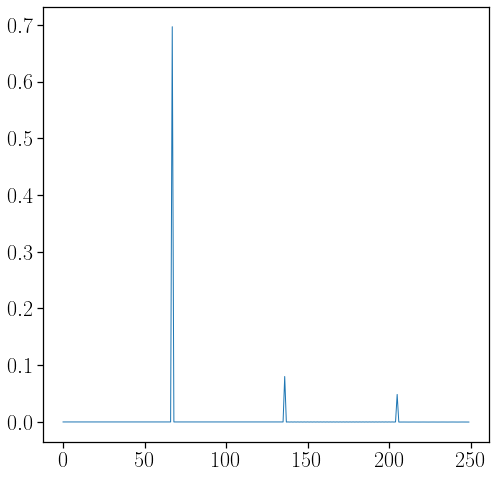

In [224]:


#hy_plot = hy[]

# hy_plot

plt.figure(figsize=(8,8))

# plt.plot(phiEven1,energyEven1, linewidth=0, marker='o', markersize=0.1)

plt.plot(ez2[:,20], linewidth='1')

In [228]:
from scipy.fft import fft

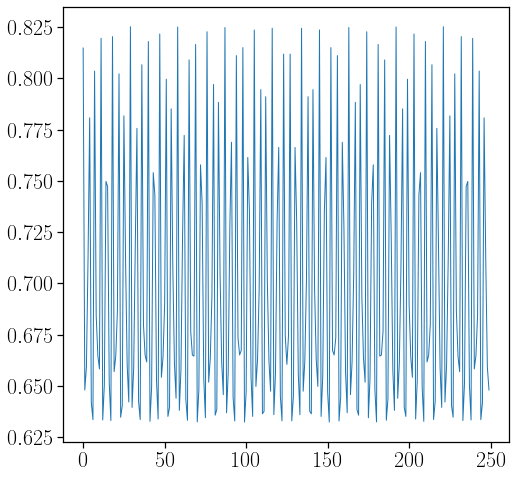

In [235]:
plt.figure(figsize=(8,8))

fft_ez2 = fft(ez2[:,20])

plt.plot(np.absolute(fft_ez2), linewidth='1')

In [236]:
ez1, hy1, ez2, hy2, ezLoop, hyLoop = run(50,50,70, omega=0.7, maxTime=450, coupling=0.4, loss=0.0002)


<ipython-input-196-4dabdf741fb3>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  ezLoop[qTime-1][0], ez2[qTime-1][0] = coupleTest(ezLoop[qTime-1][-1], ez1[qTime][-1], coupling)
<ipython-input-196-4dabdf741fb3>:35: ComplexWarning: Casting complex values to real discards the imaginary part
  ez1[0][0] = np.exp(1j*k*0)*np.exp(-1*1j*omega*qTime)


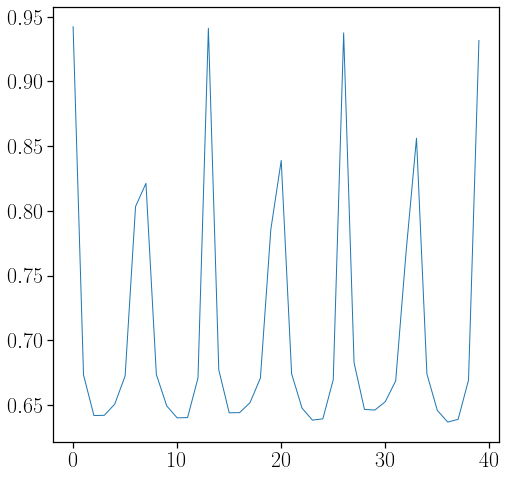

In [238]:
plt.figure(figsize=(8,8))

fft_ez2 = fft(ez2[:,20])

plt.plot(np.absolute(fft_ez2[300:340]), linewidth='1')

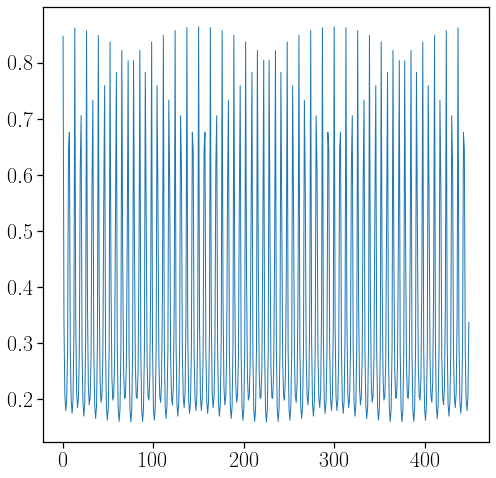

In [240]:
plt.figure(figsize=(8,8))

fft_ezLoop = fft(ezLoop[:,20])

plt.plot(np.absolute(fft_ezLoop), linewidth='1')